In [23]:
import sys
sys.path.append('..')

In [38]:
import os
import pickle

import tqdm
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.svm import SVC

from src import credit_utils as cred

## Load simulation data

In [18]:
DATA_BASE_PATH = '../out'
REPORT_NAME_REGEX = 'group_poisoning'

In [19]:
report_filenames = !ls {DATA_BASE_PATH} | grep {REPORT_NAME_REGEX}
print('Number of reports:', len(report_filenames))

Number of reports: 30


In [21]:
report_paths = [os.path.join(DATA_BASE_PATH, name) for name in report_filenames]
sim_datasets = []
for report_path in report_paths:
    with open(report_path, 'rb') as f:
        cum_group_scores, cum_group_datasets = pickle.load(f)
    sim_datasets.append(cum_group_datasets)    

## Restore the poisoned models

In [35]:
df, df_X, df_y = cred.load_dataframes('../data/german_credit_data.csv')
X, y, X_train, y_train, X_test, y_test = cred.to_numpy_data(df_X, df_y)
clf, svm_params = cred.train_model(X_train, y_train, X_test, y_test)

Shape of X: (1000, 38). Shape of y: (1000,).
Best score is: 74.22%. Best params is: {'C': 10, 'kernel': 'rbf'}.
Test score is: 77.00%.


In [71]:
models_by_sim = []
for sim in tqdm.tqdm_notebook(sim_datasets):
    sim_models = []
    for dataset in sim:
        X_train_adv, y_train_adv = dataset
        clf_poisoned = SVC(probability=True, **svm_params).fit(
            X_train_adv, y_train_adv)
        sim_models.append(clf_poisoned)
    models_by_sim.append(sim_models)

## Visualize the effects of poisoning

In [105]:
sns.set_context('paper')

In [64]:
def score(clf, group):
    return np.mean(clf.predict(group) == 1)

In [65]:
target_group_sel = (df['Checking account_little'] == 1) & \
                   (df['Saving accounts_little'] == 1) & \
                   (df['Risk_good'] == 0)

target_group = X[target_group_sel]
len(target_group), score(clf, target_group)

(114, 0.30701754385964913)

In [66]:
control_group_0_sel = np.ones(len(X), dtype=bool) ^ target_group_sel
control_group_0 = X[control_group_0_sel]
len(control_group_0), score(clf, control_group_0)

(886, 0.8860045146726863)

In [67]:
control_group_1_sel = (df['Checking account_moderate'] == 1) & \
                      (df['Risk_good'] == 1)
control_group_1 = X[control_group_1_sel]
len(control_group_1), score(clf, control_group_1)

(164, 0.9329268292682927)

In [95]:
groups = {
    'Target': target_group,
    'Everyone else': control_group_0,
    # 'Moderate': control_group_1
}
group_scores_df = pd.DataFrame(
    columns=['sim', 'poison_size', 'group', 'score'])

for sim_num, sim_models in enumerate(tqdm.tqdm_notebook(models_by_sim)):
    for poison_size, clf_adv in enumerate([clf] + sim_models):
        for group_id, group in groups.items():
            current_score = score(clf_adv, group)
            group_scores_df = group_scores_df.append(
                {'sim': sim_num,
                 'poison_size': poison_size,
                 'group': group_id,
                 'score': current_score},
                ignore_index=True)

group_scores_df.sim = group_scores_df.sim.astype(int)
group_scores_df.poison_size = group_scores_df.poison_size.astype(int)

/home/bogdan/Workspace/padML-code/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

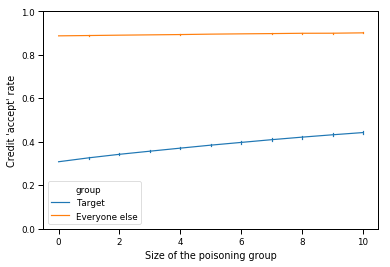

In [107]:
fig, ax = plt.subplots()
sns.lineplot(data=group_scores_df,
             x='poison_size', y='score', hue='group', ci=99,
             err_style='bars', ax=ax)

ax.set_ylim(0, 1)
ax.set_ylabel("Credit 'accept' rate")
ax.set_xlabel("Size of the poisoning group")

plt.plot()